In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
fake = pd.read_csv("C:/Users/hp/Desktop/ACADEMIC YEAR 2020-21/DATA SCIENCE/COURSE PROJECT/data/Fake.csv")
true = pd.read_csv("C:/Users/hp/Desktop/ACADEMIC YEAR 2020-21/DATA SCIENCE/COURSE PROJECT/data/True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

In [5]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
# Check the data
data.head()

,title,text,subject,date,target
0,FACTBOX - German coalition watch: Agreeing on ...,BERLIN (Reuters) - Chancellor Angela Merkel wo...,worldnews,"October 15, 2017",true
1,Republican West Virginia Lawmaker Wants You T...,Whenever Republicans dredge up a certain speci...,News,"April 29, 2016",fake
2,HORRIBLE News For Do-Nothing GOP: Americans S...,Republican lawmakers oppose paid family leave....,News,"May 20, 2016",fake
3,Rubio under attack as New Hampshire primary ra...,WASHINGTON (Reuters) - Republican presidential...,politicsNews,"February 4, 2016",true
4,Bill Maher Explains Socialism To Republicans ...,"Until recently, socialism has been one of th...",News,"June 4, 2016",fake


In [9]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,FACTBOX - German coalition watch: Agreeing on ...,BERLIN (Reuters) - Chancellor Angela Merkel wo...,worldnews,true
1,Republican West Virginia Lawmaker Wants You T...,Whenever Republicans dredge up a certain speci...,News,fake
2,HORRIBLE News For Do-Nothing GOP: Americans S...,Republican lawmakers oppose paid family leave....,News,fake
3,Rubio under attack as New Hampshire primary ra...,WASHINGTON (Reuters) - Republican presidential...,politicsNews,true
4,Bill Maher Explains Socialism To Republicans ...,"Until recently, socialism has been one of th...",News,fake


In [10]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,BERLIN (Reuters) - Chancellor Angela Merkel wo...,worldnews,true
1,Whenever Republicans dredge up a certain speci...,News,fake
2,Republican lawmakers oppose paid family leave....,News,fake
3,WASHINGTON (Reuters) - Republican presidential...,politicsNews,true
4,"Until recently, socialism has been one of th...",News,fake


In [11]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,berlin (reuters) - chancellor angela merkel wo...,worldnews,true
1,whenever republicans dredge up a certain speci...,News,fake
2,republican lawmakers oppose paid family leave....,News,fake
3,washington (reuters) - republican presidential...,politicsNews,true
4,"until recently, socialism has been one of th...",News,fake


In [12]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
# Check
data.head()

,text,subject,target
0,berlin reuters chancellor angela merkel won a...,worldnews,true
1,whenever republicans dredge up a certain speci...,News,fake
2,republican lawmakers oppose paid family leave ...,News,fake
3,washington reuters republican presidential ca...,politicsNews,true
4,until recently socialism has been one of the...,News,fake


In [14]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
data.head()

,text,subject,target
0,berlin reuters chancellor angela merkel fourth...,worldnews,true
1,whenever republicans dredge certain specious q...,News,fake
2,republican lawmakers oppose paid family leave ...,News,fake
3,washington reuters republican presidential can...,politicsNews,true
4,recently socialism one dirtiest words someone ...,News,fake


subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


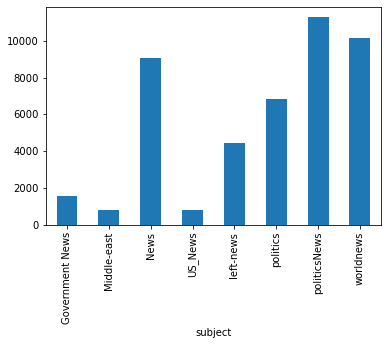

In [16]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


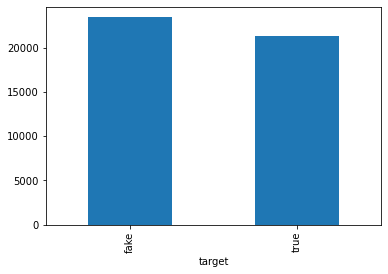

In [17]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

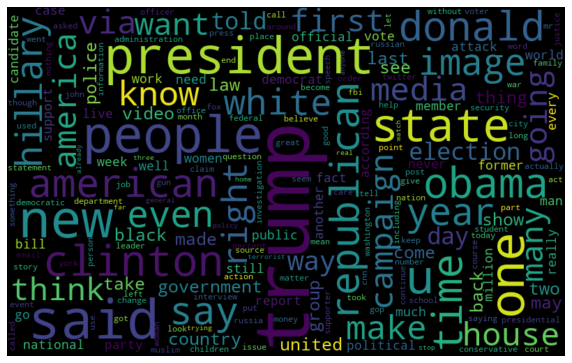

In [18]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

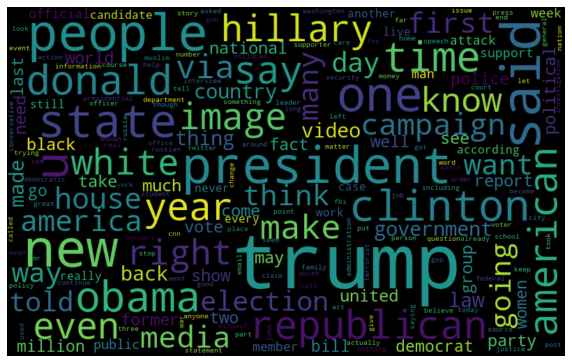

In [19]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

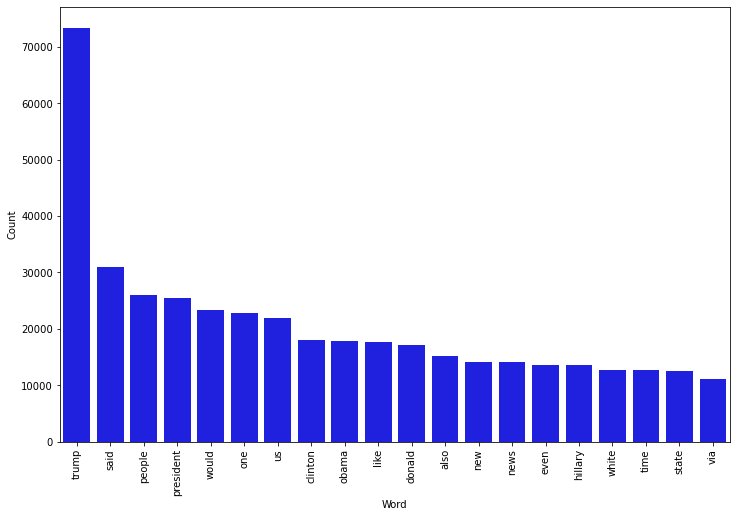

In [21]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

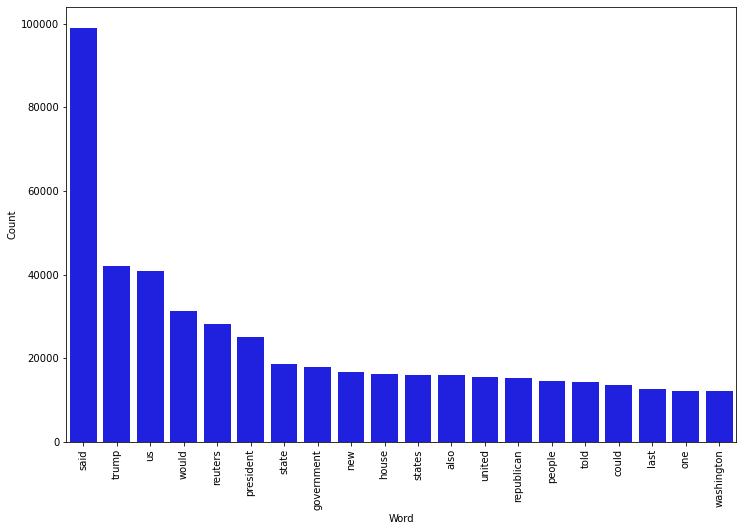

In [22]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

In [23]:
# Function to plot the confusion matrix 
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [30]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(classification_report(y_test, prediction, target_names = ['fake', 'true']))

accuracy: 99.08%
              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      4639
        true       0.99      0.99      0.99      4341

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



Confusion matrix, without normalization


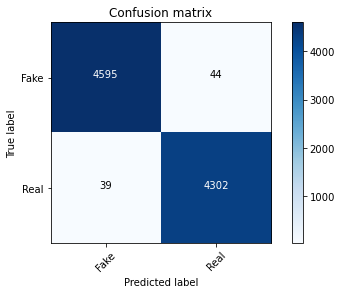

In [27]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [31]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(classification_report(y_test, prediction, target_names = ['fake', 'true']))

accuracy: 99.59%
              precision    recall  f1-score   support

        fake       1.00      1.00      1.00      4639
        true       1.00      0.99      1.00      4341

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



Confusion matrix, without normalization


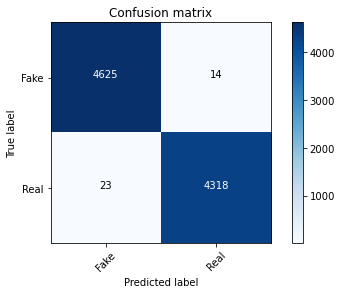

In [29]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])